<a href="https://colab.research.google.com/github/AmDeep/AI_LaunchLab_Team3/blob/main/Data_preprocessing_LT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the data out of xarray

In [7]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import xarray as xa

In [13]:
!pip install netcdf4

     |████████████████████████████████| 4.7MB 5.5MB/s 
     |████████████████████████████████| 327kB 33.5MB/s 


This is preprocessing for now, can be run anywhere

In [3]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13021         566        9896           0        2557       12188
Swap:             0           0           0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
INPUT_FILE = 'drive/MyDrive/Data/Climate/SR/super_resolution_sample.nc'

In [14]:
d = xa.open_dataset(INPUT_FILE, group='/train/x') 

In [15]:
data_y=xa.open_dataset(INPUT_FILE, group='/train/y') 

In [16]:
kept_vars = d.drop_vars(['time', 'h', 'mg_delta', 'me_delta', 'zp_delta', 'vg_delta', 'td', 'pn', 'nt', 'rt', 'i4', '5p', 'i6'])

In [17]:
kept_vars

<xarray.Dataset>
Dimensions:  (time: 20, x: 256, y: 256)
Dimensions without coordinates: time, x, y
Data variables:
    tt       (time, x, y) float32 ...
    uu       (time, x, y) float32 ...
    vv       (time, x, y) float32 ...

In [18]:
x = np.array(kept_vars.to_array())
y=np.array(data_y.to_array())

In [19]:
def shape_data(x, y):
  x = x.transpose(1, 2, 3, 0)
  y= y.transpose(1,2,3,0)
  x_tens=torch.tensor(x, dtype=torch.float)
  y_tens=torch.tensor(y, dtype=torch.float) 
  x_tens= x_tens.permute(0,3,1,2)
  y_tens= y_tens.permute(0,3,1,2)

  return x_tens, y_tens

In [20]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [21]:
def crop_images(x_tens, y_tens, x_features=3):
  #input has to be x.shape: torch.Size([ 20, x_features,256, 256])
                #  y.shape: torch.Size([20, 1, 256, 256])
  new_images=[]
  x_tens=x_tens.permute(1,0,2,3)
  #tensor=torch.tensor(dtype=torch.float)
  

  #For each feature of x (ex:tt, uu, vv etc..) crop image and then organize it in a tensor
  for i in range(x_features):
    new_images=[]
    for img in x_tens[i][:]:
          image=crop_center(img,cropx=64,cropy=64)
          image=np.array(image)
          new_images.append(image)

    new_images=np.array(new_images)
   # print(new_images.shape)
    new_x_tens=torch.tensor(new_images, dtype=torch.float).unsqueeze(1)
    if i==0:
      x_tensor=new_x_tens
    else:
      x_tensor=torch.cat((x_tensor, new_x_tens), 1)

 # DO the same for y 
  new_images=[]

  for img in y_tens.squeeze():
        image=crop_center(img,cropx=64,cropy=64)
        image=np.array(image)
        new_images.append(image)
      
  new_images=np.array(new_images)
  #print(new_images.shape)
  y_tensor=torch.tensor(new_images, dtype=torch.float).unsqueeze(1)
    
  return x_tensor, y_tensor



In [22]:
x_tensor,y_tensor=shape_data(x,y)

In [23]:
cropped_x, cropped_y= crop_images(x_tensor,y_tensor, x_features=3)

In [24]:
def display_images(x, x_hat, num_im=1, label=None):
    x= x.permute(1,0,2,3)
    x=x[0][:]
    for N in range(num_im):
        if x is not None:
            x_im = x.data.cpu().view(-1, 64, 64)
            plt.figure(figsize=(18, 4))
    #        plt.subtitle(label + ' – initial image / reconstructed image', color='black', fontsize=12)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(x_im[i+4*N])
                plt.axis('off')
        x_hat_im = x_hat.data.cpu().view(-1, 64, 64)
        plt.figure(figsize=(18, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(x_hat_im[i+4*N])
            plt.axis('off')

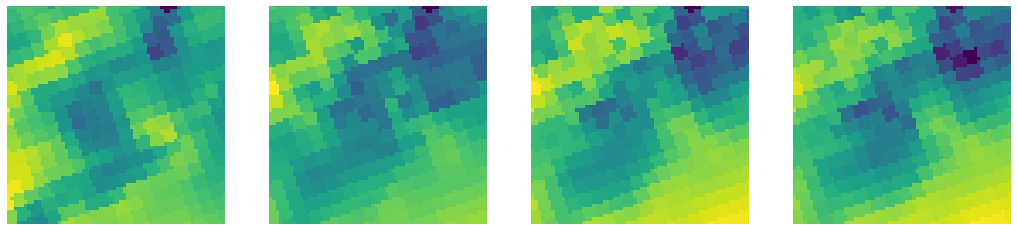

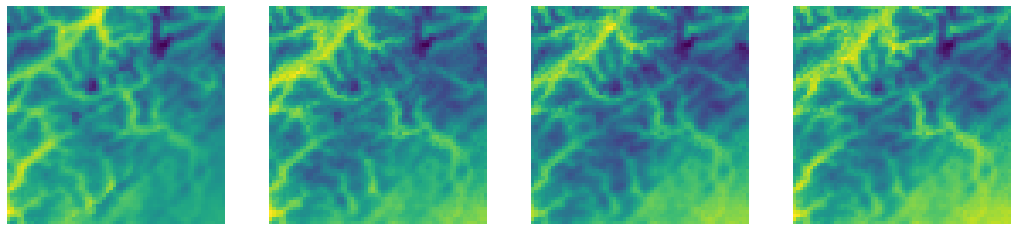

In [25]:
 display_images(cropped_x, cropped_y, num_im=1, label=None )

In [26]:
d.close()
data_y.close()